<a href="https://colab.research.google.com/github/stemgene/Computer-Vision-Projects/blob/main/00_CNN_basic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://www.bilibili.com/video/BV1oJ411d73Q/?spm_id_from=pageDriver&vd_source=81884c519d60bbdad4b6fd87d340415f

In [6]:
import tensorflow as tf
import torch
from torch import nn
import numpy as np

# shape计算

* W: input shape
* F: kernel size / pool size
* S: stride
* D: Dilation 扩张

If `padding == "SAME": output.shape = ceil(input.shape / strides) = ceil(W/S). 和kernel size没有关系。右侧或下侧进行填充，使得tensor中全部元素均参与计算

If `padding == "VALID": output.shape = ceil((input - (filter - 1)) \* dilation_rate / strides) = (W - (F - 1) * D) / S。当conv不指定padding参数时，默认的是valid。不进行任何填充，tensor中右侧的部分列，下侧的部分行不参与计算

In [ ]:
x = tf.constant([[1., 2., 3.], [4., 5., 6.]])
x = tf.reshape(x, [1, 2, 3, 1])  # give a shape accepted by tf.nn.max_pool

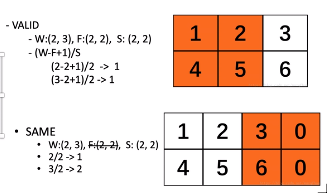

In [ ]:
valid_pad = tf.nn.max_pool(x, [1, 2, 2, 1], [1, 2, 2, 1], padding="VALID")  # 第一个[1, 2, 2, 1]是kernel size == 2*2， 第二个[1, 2, 2, 1]是stride == 2*2
valid_pad.get_shape()

TensorShape([1, 1, 1, 1])

In [ ]:
valid_pad

<tf.Tensor: shape=(1, 1, 1, 1), dtype=float32, numpy=array([[[[5.]]]], dtype=float32)>

In [ ]:
same_pad = tf.nn.max_pool(x, [1, 2, 2, 1], [1, 2, 2, 1], padding="SAME")
same_pad.get_shape()

TensorShape([1, 1, 2, 1])

In [ ]:
same_pad

<tf.Tensor: shape=(1, 1, 2, 1), dtype=float32, numpy=
array([[[[5.],
         [6.]]]], dtype=float32)>

## example of calculation

以vgg16为例，实际计算输入和输出的size

In [ ]:
# Block 1
x = [1, 224, 224, 3]
x = layers.Conv2D(64, (3, 3), padding="SAME", activation='relu')(x)  # SAME: size = w / s, 因为s=1， 所以w不变
x = layers.Conv2D(64, (3, 3), padding="SAME", activation='relu')(x)  # SAME: size = w / s, 因为s=1， 所以w不变
x = layers.MaxPooling2D((2, 2), strides=(2, 2))(x)   # 默认valid，size = (224 - 2 + 1)/2 = 112

NameError: ignored

# Batch Norm

`torch.nn.BatchNorm3d(num_features, eps=1e-5, momentum=0.1, affine=True)`

* 优点：训练收敛快，部分解决过拟合
* 针对一个batch内的特征进行归一化
* 原有的Normalization只在数据输入前进行一次。但BN是针对每一层layer都要做，相当于对前一层的输出进行BN
* Norm的两个参数就是mean=0和std=1.但BN增加了两个参数gamma和beta进行affine仿射变换，而且这两个参数是可学习的。如果设置`affine=False`, 则不学习这两个参数，而只是进行mean=0，std=1的设置。
* 不改变shape
    * 1D：输入n \* d，输出n * d。作用在特征向量d这个维度上
    * 2D：输入n \* c \* H \* W, 输出n \* c \* H \* W。作用在c这个维度上
    * 3D：输入n \* c \* d \* H \* W, 输出n \* c \* d \* H \* W。作用在c这个维度上

针对1D的BN，一个batch有4个样本：
`x=troch.randn(4, 10)`

|entry\feature| 0 | 1 | 2 | ... | 9|
| --          | --| --|--|  -- | -- |
| 0           | 0.1 | 0.32 | 0.89 | ... | 23|
| 1          | 0.2 | 0.234|0.653| ... |11|
|2           | 0.2 | 0.12| 0.534| ... | 23|
|3          | 0.4 | 0.27| 0.82| ... | 15|
|mean&std  | $\mu$, σ| $\mu$, σ| $\mu$, σ|...| $\mu$, σ|

`m=nn.BatchNorm1d(10)`

对每一列（feature）求mean和std，得到$\frac{x[:][0]-μ}{σ}*γ+β$,即第0列的归一化。

有多少个feature就对应着多少个γ和β: (γ_0, β_0)...(γ_9, β_9)

此时可以看到model.weight和model.bias都是1d，长度为(10,)的

## 1D 的BN计算

In [ ]:
x = torch.randn(4, 5) # 4个sample，每个sample有5个feature
x

tensor([[ 0.4644, -0.1539, -0.3133, -0.8965, -0.0549],
        [ 0.0273, -0.5306, -3.4589, -1.4827,  0.6438],
        [ 0.9425,  1.7346, -1.6768, -0.6122,  1.6988],
        [ 0.0073, -0.6243, -0.8568, -0.6071,  0.5422]])

In [ ]:
m = nn.BatchNorm1d(5)    # nn.BatchNorm()中的值是非batch之后的第一个维度的值。如一维的5个feature，如果是三维图像，那就是channel的个数
m.weight  # gamma

Parameter containing:
tensor([1., 1., 1., 1., 1.], requires_grad=True)

在创建BN层时，如果没有设置affine=False，则自动给weight和bias赋值，而weight就是γ, bias就是β。可以理解，γ和β就是另外一层线性方程的weight和bias

In [ ]:
m.bias  # beta

Parameter containing:
tensor([0., 0., 0., 0., 0.], requires_grad=True)

In [ ]:
output = m(x)
output

tensor([[ 0.2718, -0.2722,  1.0612,  0.0088, -1.2072],
        [-0.8706, -0.6661, -1.5815, -1.6358, -0.1008],
        [ 1.5218,  1.7024, -0.0843,  0.8063,  1.5697],
        [-0.9230, -0.7641,  0.6046,  0.8207, -0.2617]],
       grad_fn=<NativeBatchNormBackward0>)

In [ ]:
output.mean(dim=0)

tensor([ 2.9802e-08,  1.4901e-08, -5.9605e-08,  8.9407e-08, -1.1176e-07],
       grad_fn=<MeanBackward1>)

In [ ]:
output.std(dim=0)

tensor([1.1547, 1.1547, 1.1547, 1.1547, 1.1547], grad_fn=<StdBackward0>)

有偏估计

In [ ]:
output.std(dim=0, unbiased=False)

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000], grad_fn=<StdBackward0>)

接下来手动计算一下，即手动计算x的mean和std，看看是否和BN之后的结果一致。

首先是x的mean

In [ ]:
mean = x.mean(dim=0)
mean

tensor([ 0.3604,  0.1065, -1.5765, -0.8996,  0.7075])

In [ ]:
std = torch.sqrt(1e-5 + torch.var(x, dim=0, unbiased=False))
std

tensor([0.3825, 0.9563, 1.1903, 0.3565, 0.6316])

In [ ]:
(x - mean) / std

tensor([[ 0.2718, -0.2722,  1.0612,  0.0088, -1.2072],
        [-0.8706, -0.6661, -1.5815, -1.6358, -0.1008],
        [ 1.5218,  1.7024, -0.0843,  0.8063,  1.5697],
        [-0.9230, -0.7641,  0.6046,  0.8207, -0.2617]])

结果和通过BN层一致

In [ ]:
m(x)

tensor([[ 0.2718, -0.2722,  1.0612,  0.0088, -1.2072],
        [-0.8706, -0.6661, -1.5815, -1.6358, -0.1008],
        [ 1.5218,  1.7024, -0.0843,  0.8063,  1.5697],
        [-0.9230, -0.7641,  0.6046,  0.8207, -0.2617]],
       grad_fn=<NativeBatchNormBackward0>)

## 2D数据 计算BN

对于图像数据(3, 2, 2), BN操作相当于针对batch中所有样本的同一个channel上图像的值（长*宽）进行展平并做归一化

In [2]:
x = torch.randn(2, 3, 2, 2) # 2个样本，每个样本是3个c，长宽是2*2
x

tensor([[[[-2.1113,  0.3627],
          [-0.4079, -0.9562]],

         [[-0.2413, -0.3950],
          [ 1.8579,  0.0804]],

         [[ 1.6640, -2.0369],
          [ 1.4282,  0.0885]]],


        [[[ 0.3476, -1.0444],
          [-0.1256,  0.1206]],

         [[ 0.4950, -0.5715],
          [ 0.5880,  0.4850]],

         [[-0.9668, -1.2595],
          [ 0.3531,  0.8706]]]])

In [3]:
m = nn.BatchNorm2d(3)  # 针对三维图像，函数中的传入参数是chanel个数
m

BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

In [4]:
m.weight, m.bias

(Parameter containing:
 tensor([1., 1., 1.], requires_grad=True),
 Parameter containing:
 tensor([0., 0., 0.], requires_grad=True))

In [5]:
m(x)

tensor([[[[-2.0485,  1.0522],
          [ 0.0863, -0.6008]],

         [[-0.7326, -0.9456],
          [ 2.1767, -0.2867]],

         [[ 1.3242, -1.6525],
          [ 1.1345,  0.0570]]],


        [[[ 1.0333, -0.7114],
          [ 0.4402,  0.7487]],

         [[ 0.2879, -1.1903],
          [ 0.4167,  0.2740]],

         [[-0.7918, -1.0272],
          [ 0.2698,  0.6860]]]], grad_fn=<NativeBatchNormBackward0>)

选择第一个channel上的值进行验证

In [7]:
t = [-2.0485,  1.0522, 0.0863, -0.6008, 1.0333, -0.7114, 0.4402,  0.7487] # t就是两个sample第一个channel的值，展平处理
np.mean(t)

0.0

In [8]:
np.std(t)  # np默认的ddaf已经是0了，默认是有偏的

1.0000007499997188

# Layer Norm

* 针对每个样本内部进行归一化，不需要跨batch
* 作用地点在最后一个维度。对于图像来说，作用点既可以是W，H和W，或CHW一起作用。
* 输入和输出的shape不变

![img](https://pytorch.org/docs/stable/_images/layer_norm.jpg)

In [13]:
# NLP Example, 20个样本，每个样本5个句子，每个句子的特征向量是10
batch, sentence_length, embedding_dim = 20, 5, 10
embedding = torch.randn(batch, sentence_length, embedding_dim)
layer_norm = nn.LayerNorm(embedding_dim)
# Activate module
output = layer_norm(embedding)

手动验证

In [14]:
output.shape

torch.Size([20, 5, 10])

In [15]:
output[0, 0, :].mean()

tensor(-1.1921e-08, grad_fn=<MeanBackward0>)

In [16]:
output[0, 0, :].std(unbiased=False)

tensor(1.0000, grad_fn=<StdBackward0>)

In [17]:
layer_norm.weight

Parameter containing:
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], requires_grad=True)

Image Example

In [18]:
N, C, H, W = 20, 5, 10, 10
input = torch.randn(N, C, H, W)
# Normalize over the last three dimensions (i.e. the channel and spatial dimensions)
# as shown in the image below
layer_norm = nn.LayerNorm([C, H, W])
output = layer_norm(input)

In [19]:
output[0, :].mean()

tensor(1.2398e-08, grad_fn=<MeanBackward0>)

In [20]:
output[0, :].std(unbiased=False)

tensor(1.0000, grad_fn=<StdBackward0>)